In [2]:
from datasets import load_dataset, Dataset
import pandas as pd
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer, BertForSequenceClassification
from sklearn.model_selection import train_test_split

import pandas as pd
import numpy as np

from tabulate import tabulate
from tqdm import trange
import random
from transformers import DataCollatorWithPadding

from transformers import AutoTokenizer
import json

/home/mms9355/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
#load model
model = BertForSequenceClassification.from_pretrained("models/model_mrda_v2_t1.model/")

# labels =  ["dummy", "question", "validate", "reject", "unsure", "backchannel", "self-talk", "communication"]
# labels = [ "dummy", "state", "external source", "validate", "reject", "inquire", "direct"]
labels = ["statement", "declarative question", "backchannel", "follow-me", "question"]
id2label = {idx:label for idx, label in enumerate(labels)}
label2id = {label:idx for idx, label in enumerate(labels)}

In [4]:
#quick prototyping using sed, TODO change to python re module
import subprocess
import os

import re
from dateutil import parser

cwd = os.getcwd()

nek19_chat_df = pd.DataFrame()

for session in range(1,9):
    f_cmd = cwd + '/data/Project_RED/Cost\ of\ Conflict/chat\ log\ data/NEK19_{}.txt'.format(session)
    f = re.sub(r"\\", "", f_cmd)
    f_out_cmd = f_cmd + '.mod'
    f_out = re.sub(r"\\", "", f_out_cmd)
    cmd = cwd + '/convert_nek.sh {} {}'.format(f_cmd, f_out_cmd)
    out = subprocess.run(cmd, shell=True, capture_output=True).stdout

    s_df = pd.read_json(f_out)
    s_df = s_df.drop(columns=['_id', 'timeZone'])
    s_df['creationDateTime'] = s_df['creationDateTime'].apply(parser.parse)
    delt = s_df['creationDateTime'].iloc[-1]  - s_df['creationDateTime'].iloc[0]
    delt/3
    def aux(time):
        if(time < s_df['creationDateTime'].iloc[0] + delt/3): 
            return 0
        elif(time < s_df['creationDateTime'].iloc[0] + 2*delt/3):
            return 1
        else:
            return 2
    s_df['time'] = s_df['creationDateTime'].map(aux)
    s_df['session'] = session
    nek19_chat_df = pd.concat([nek19_chat_df, s_df])
nek19_chat_df = nek19_chat_df.drop('creationDateTime',axis=1).reset_index(drop=True)
nek19_chat = Dataset.from_pandas(nek19_chat_df)

In [5]:
f_out = "/home/mms9355/RED_dialogue/data/Project_RED/Cost of Conflict/chat log data/NEK19_1.txt.mod"
s_df = pd.read_json(f_out)
s_df

,_id,content,creationDateTime,recipient,sender,sentOnBehalfOf,session,timeZone
0,5c9762a32d0e1457b3c9c930,Hello! Please confirm when the crew is online ...,2019-03-24T10:57:39.127+0000,eng3,vc3,vc3,5c97609c2d0e1457b3c9c80f,America/Chicago
1,5c9763fd2d0e1457b3c9e019,Hydrogeologist: Hello Geo!\n,2019-03-24T11:03:25.985+0000,teamGeo,teamGeo,geo1,5c97609c2d0e1457b3c9c80f,America/Chicago
2,5c9764342d0e1457b3c9e562,Session start,2019-03-24T11:04:20.278+0000,geo2,geo3,geo3,5c97609c2d0e1457b3c9c80f,America/Chicago
3,5c97693f2d0e1457b3ca9673,Hello! Please confirm when the crew is online ...,2019-03-24T11:25:51.606+0000,eng2,vc3,vc3,5c97609c2d0e1457b3c9c80f,America/Chicago
4,5c9769462d0e1457b3ca9776,Hello! Please confirm when the crew is online ...,2019-03-24T11:25:58.223+0000,con1,vc3,vc3,5c97609c2d0e1457b3c9c80f,America/Chicago
...,...,...,...,...,...,...,...,...
133,5c97762a2d0e1457b3cdfeba,"They are saying that the time is up, could you...",2019-03-24T12:20:58.436+0000,con1,con2,con2,5c97609c2d0e1457b3c9c80f,America/Chicago
134,5c97764f2d0e1457b3ce0866,Sedimentologist: stop,2019-03-24T12:21:35.890+0000,teamGeo,teamGeo,geo3,5c97609c2d0e1457b3c9c80f,America/Chicago
135,5c9776512d0e1457b3ce08e8,stop,2019-03-24T12:21:37.639+0000,geo3,geo2,geo2,5c97609c2d0e1457b3c9c80f,America/Chicago
136,5cb499f52d0e2038b3b9e117,Hello!,2019-04-15T14:49:25.870+0000,geo3,geo1,geo1,5c97609c2d0e1457b3c9c80f,America/Chicago


In [6]:
nek19_chat['content']

['Hello! Please confirm when the crew is online and ready to begin.',
 'Hydrogeologist: Hello Geo!\n',
 'Session start',
 'Hello! Please confirm when the crew is online and ready to begin. ',
 'Hello! Please confirm when the crew is online and ready to begin. ',
 'Hello! Please confirm when the crew is online and ready to begin. ',
 'Hello! Please confirm when the crew is online and ready to begin. ',
 'hi',
 'Greetings',
 'test',
 'Structural Geologist: Testing',
 'Hi!',
 'Hi, baby',
 'ok',
 'Hello\n',
 'O, Yeah!\n',
 'hello\n',
 'official start',
 'Hello! ',
 'Good afternoon!',
 'Hi!\n',
 'Hydrogeologist: hello!',
 'Hello, we are ready!\n',
 'Maintenance Specialist: Good afternoon!',
 'Biochemical Engineer: Hi team, any preference on where we begin?',
 'hi\n',
 'Hi!',
 'Hi!\n',
 'Hi Justin, this is Harrison',
 'Sedimentologist: is someone logging in as the drilling specialist at Sirius?\n',
 'Hello! \n',
 'Hi!\n',
 'Sydney; this is Harrison',
 'Operations Specialist: Hello, no, drill

In [7]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

def preproccess(samples):
    encoding = tokenizer.encode_plus(samples['content'], add_special_tokens = True,
                        max_length = 32,
                        return_attention_mask = True,
                        return_tensors = 'pt',
                        truncation=True,
                        padding="max_length")
        
    samples['input_ids'] = encoding['input_ids']
    samples['token_type_ids'] = encoding['token_type_ids']
    samples['attention_mask'] = encoding['attention_mask']
    return samples

nek19_chat = nek19_chat.map(preproccess)
nek19_chat.set_format('torch')

In [8]:
from torch import tensor


def classify(samples):
    out = model(samples['input_ids'], token_type_ids=samples['token_type_ids'], attention_mask=samples['attention_mask'])
    logits = out.logits.detach().cpu().numpy()

    samples['logits'] = logits[0]
    # samples['labels_h'] = labels[logits.argmax()]
    samples['labels_h'] = labels[logits.argmax()-1]
    samples['labels'] = logits.argmax()
    if(re.match("^.*lease confirm when.*$", samples['content'])):
        samples['labels'] = tensor(0)
        samples['labels_h'] = 'dummy'
    return samples
nek19_chat = nek19_chat.map(classify)

In [9]:
nek19_chat[5]

{'content': 'Hello! Please confirm when the crew is online and ready to begin. ',
 'recipient': 'con3',
 'sender': 'vc3',
 'sentOnBehalfOf': 'vc3',
 'session': tensor(1),
 'time': tensor(0),
 'input_ids': tensor([[  101,  7592,   999,  3531, 12210,  2043,  1996,  3626,  2003,  3784,
           1998,  3201,  2000,  4088,  1012,   102,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0]]),
 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0, 0, 0, 0]]),
 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0, 0, 0, 0]]),
 'logits': tensor([ 5.6075, -5.7186, -7.9057, -7.7690, -8.3503]),
 'labels_h': 'dummy',
 'labels': tensor(0)}

In [10]:
# Taken from megans code
from pathlib import Path
from string import punctuation



tran_path = Path('data/Project_RED/Cost of Conflict/transcript data')
tran_list = list(tran_path.glob('*.txt'))
transcripts = {}
time = 0
for filepath in tran_list:
    name = Path(filepath).stem
    with open(filepath,'r',encoding='utf-8') as my_file:
        data = my_file.readlines()
        clean = []
        if "MAG" in name:
            for line in data:
                if line[:1].isalpha() == True and "Joy " not in line[:4]:
                    clean.append(line)
        else:
            for line in data:
                if ":" in line and line[:1].isnumeric() == False:
                    clean.append(line.strip() + "&&" +  str(time))
                elif ":" in line and line[:1].isnumeric() == True:
                    time +=1
        transcripts[name] = clean

def check_trans(word_list, messages):
    all_words = {}
    counter = {} # includes actual words from conversation
    dict_counter = {} # includes words from dictionary
    
    for message in messages:
        content = message.split(" ")
        for word in content:
            word = word.strip(punctuation).lower()
            if len(word)>1:
                if word in all_words:
                    all_words[word] += 1
                elif word.isalpha() == True:
                    all_words[word] = 1
                else:
                    if word[0].isnumeric() == False:
                        for symbol in punctuation:
                            if symbol in word:
                                split_word = word.split(symbol)
                                for section in split_word:
                                    if len(section) > 1:
                                        if word in all_words:
                                            all_words[word] += 1
                                        else:
                                            if word.isalpha() == True:
                                                all_words[word] = 1
                for check in word_list:
                    find = re.match(check, word)
                    if find != None:
                        if check[-1] != "*":
                            if len(word) > find.span()[1]:
                                continue
                        else:
                            if len(word) < len(check):
                                continue
                        if word not in counter:
                            counter[word] = 1
                        else:
                            counter[word] += 1
                        if check not in dict_counter:
                            dict_counter[check] = 1
                        else:
                            dict_counter[check] += 1
    return counter, dict_counter, all_words


In [11]:
# session = transcripts[list(transcripts.keys())[0]]
last_time = 0
nek21_trans_df = pd.DataFrame()
for session in transcripts:
   s_df = pd.DataFrame.from_dict(transcripts[session])
   def trans_proccess(c): 

      global g_time
      x=c[0].strip()
      # print(x)
      try:
         speaker = re.search(r"^[^:]*:\s*", x).group()[:-2]
      except:
         speaker = ""
      try:
         content = re.search(r":(.*)&&", x).group()[1:-2]
      except:
         content = ""
      try:
         time = int(re.search(r"&&.*", x).group()[2:])
         g_time = time
      except:
         time = -1

      if(speaker == "" and content == ""):
         speaker = None
         content = None

      row = pd.Series()

      row['speaker'] = speaker
      row['content'] = content
      row['block'] = time-last_time
      row['session'] = session
      return row
   nek21_trans_df = pd.concat([nek21_trans_df, s_df.apply(lambda x: trans_proccess(x), axis=1)])
   last_time = g_time
   # print(str(session) + ": " + str(last_time))
nek21_trans_df = nek21_trans_df.dropna()
nek21_trans_df = nek21_trans_df[nek21_trans_df['block'] >= 0].reset_index(drop=True)
nek21_trans_df

,speaker,content,block,session
0,Legen,,0,NEK21_20211130_NEK
1,Ashley,And then //press the red button.,0,NEK21_20211130_NEK
2,Oleg,//[UI],0,NEK21_20211130_NEK
3,Ashley,"Okay. Today is November 30th, 2021. It’s miss...",0,NEK21_20211130_NEK
4,All,//Mark.,0,NEK21_20211130_NEK
...,...,...,...,...
3368,Vika,"Will, [UI], please?",130,NEK21_20220111_NEK
3369,Will,[UI],130,NEK21_20220111_NEK
3370,Vika,"Thank you, tiger.",130,NEK21_20220111_NEK
3371,Oleg,It stopped.,131,NEK21_20220111_NEK


In [12]:
# categorize

for session in transcripts:
    s = nek21_trans_df[nek21_trans_df['session'] == session]
    delt = s['block'].max()
    s['time'] = 2
    s.loc[s['block'] < 2*delt/3, 'time']= 1
    s.loc[s['block'] < delt/3, 'time']= 0
    nek21_trans_df.loc[nek21_trans_df['session'] == session,'time'] = s['time']
nek21_trans_df =nek21_trans_df.drop('block', axis=1)

/tmp/ipykernel_756616/3450827240.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  s['time'] = 2
/tmp/ipykernel_756616/3450827240.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  s['time'] = 2


In [13]:
nek19_trans = Dataset.from_pandas(nek21_trans_df)

In [14]:
nek19_trans = nek19_trans.map(preproccess)
nek19_trans.set_format('torch')

nek19_trans = nek19_trans.map(classify)

In [15]:
nek19_trans[900]

{'speaker': 'Ashley',
 'content': ' Thank you.',
 'session': 'NEK21_20211130_NEK',
 'time': tensor(2.),
 'input_ids': tensor([[ 101, 4067, 2017, 1012,  102,    0,    0,    0,    0,    0,    0,    0,
             0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
             0,    0,    0,    0,    0,    0,    0,    0]]),
 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0, 0, 0, 0]]),
 'attention_mask': tensor([[1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0, 0, 0, 0]]),
 'logits': tensor([ 5.6183, -5.7139, -7.9445, -7.7620, -8.2830]),
 'labels_h': 'question',
 'labels': tensor(0)}

In [16]:
nek19_trans[3008]

{'speaker': 'Salah',
 'content': ' Yeah.',
 'session': 'NEK21_20220111_NEK',
 'time': tensor(1.),
 'input_ids': tensor([[ 101, 3398, 1012,  102,    0,    0,    0,    0,    0,    0,    0,    0,
             0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
             0,    0,    0,    0,    0,    0,    0,    0]]),
 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0, 0, 0, 0]]),
 'attention_mask': tensor([[1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0, 0, 0, 0]]),
 'logits': tensor([-0.8546, -4.2551,  0.4676, -3.0268, -8.6118]),
 'labels_h': 'declarative question',
 'labels': tensor(2)}

In [17]:
# Check accuracy by taking a random sample of 20 (10 translated, 10 msgs)

import random 
from operator import itemgetter

n = 10
trans_sample_ind = random.sample(range(0, len(nek19_trans)), n)
chat_sample_ind = random.sample(range(0, len(nek19_chat)), n)
samples = pd.DataFrame(columns=['content', 'model_label', 'human_label', 'source'])
# pd.concat([
#     pd.DataFrame.from_dict(nek19_trans[trans_sample]),
#     pd.DataFrame.from_dict(nek19_chat[chat_sample])
#                  ])

trans_sample = itemgetter(*trans_sample_ind)(nek19_trans)
chat_sample = itemgetter(*chat_sample_ind)(nek19_chat)
samples = pd.DataFrame(columns=["source", "content", "label"])

for t in trans_sample:
    samples.loc[len(samples.index)] = ["spoken", t['content'], t['labels_h']]

for c in chat_sample:
    samples.loc[len(samples.index)] = ["chat", c['content'], c['labels_h']]

print("Unique Labels in Set: " + str(len(pd.unique(samples['label']))))
samples.to_csv('samples.csv')
samples

Unique Labels in Set: 3


,source,content,label
0,spoken,No.,question
1,spoken,"So, the scenario of the [UI] everything is ju...",question
2,spoken,"Three forty-eight. …It’s a bit deep, but I th...",question
3,spoken,"Ash. Ash, look here. Recording is on, but I ...",question
4,spoken,"As always, I will say to you – you’ll be miss...",question
5,spoken,Okay. Okay.,question
6,spoken,//But now none of the points are coming.,question
7,spoken,What about fourteen six?,follow-me
8,spoken,But I can? “You are about to sign off on…”,follow-me
9,spoken,I will be a bit slow.,question


In [18]:
# # one of each classifiers

# nek19_chat_df = nek19_chat.to_pandas()
# for i in range(0, 9):
#     try: 
#         df = nek19_chat_df[nek19_chat_df['labels'] == i][['content','labels']]
#         print(labels[i] + ": " + df.iloc[random.randint(0, len(df.index)-1)])
#     except: 
#         print("no chats with the label " + labels[i] + " were not found")
# # nek19_chat_df[nek19_chat_df['labels'] == 1][['content','labels']].iloc[30]
# # nek19_trans[nek19_trans['labels'] == tensor(0)]

In [19]:
nek21_trans_df = nek19_trans.to_pandas()
for i in range(0, len(labels)):
    content = "__NONE__"
    df = nek21_trans_df[nek21_trans_df['labels'] == i]['content']
    if(len(df.index) > 0):
        rand_sample_ind = random.randint(0, len(df.index)-1)
        if(rand_sample_ind >= 0):
            content = df.iloc[random.randint(0, len(df.index)-1)]

    print_str = labels[i] + ": " + str(len(df.index)) + " : " + content
    print(print_str)


statement: 2445 :  Forty fifty, fifty fifty.
declarative question: 10 :  //Yeah.
backchannel: 69 :  Yeah.
follow-me: 17 :  But…
question: 832 :  //It’s twenty-four thirty-five? It’s really bad for me. The depth is three kilometers. \


In [20]:
nek21_trans_df = nek19_trans.to_pandas()
for i in range(0, len(labels)):
    content = "__NONE__"
    df = nek21_trans_df[nek21_trans_df['labels'] == i]['content']
    if(len(df.index) > 0):
        rand_sample_ind = random.randint(0, len(df.index)-1)
        if(rand_sample_ind >= 0):
            content = df.iloc[random.randint(0, len(df.index)-1)]

    print_str = labels[i] + ": " + str(len(df.index)) + " : " + content
    print(print_str)


statement: 2445 :  Well, yes. It looks like it will work with some water. There are so many... there are three thousand... There we lose... two-thirds. So there is a hundred thousand left. And 60%... forty thousand is somehow, somewhere in a normal place. I mean, it’s not much, but it’s... It’s the same if we have another one, where we have a different level of loss or something.
declarative question: 10 :  //Yes.
backchannel: 69 :  Yeah.
follow-me: 17 :  I mean…
question: 832 :  They said if there are problems, we can…Okay. Can we check to make sure the website is entered correctly?


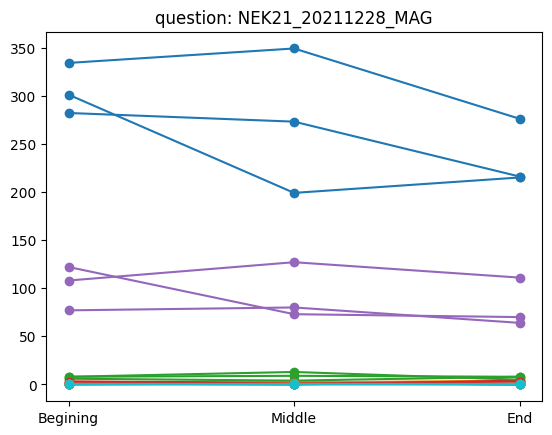

In [21]:
import matplotlib.pyplot as plt

for session in transcripts:
    for i in range(0, len(labels)):
        df = nek21_trans_df[nek21_trans_df['session'] == session]
        trans_starts = df[df['time'] == 0]
        trans_mids = df[df['time'] == 1]
        trans_ends = df[df['time'] == 2]
        ts_dist = [len(trans_starts[trans_starts['labels'] == i].index) for i in range(0, len(labels))]
        tm_dist = [len(trans_mids[trans_mids['labels'] == i].index) for i in range(0, len(labels))]
        te_dist = [len(trans_ends[trans_ends['labels'] == i].index) for i in range(0, len(labels))]
        plt.plot(["Begining", "Middle", "End"], [ts_dist[i], tm_dist[i], te_dist[i]], '-o')
        plt.title(labels[i] + ": " + session)
        # plt.show()

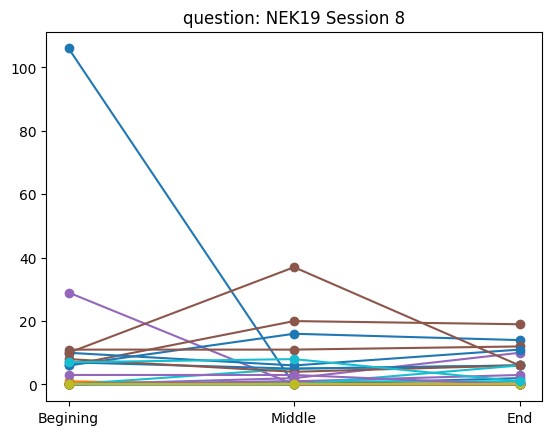

In [34]:
nek19_chat_df = nek19_chat.to_pandas()
for session in range(1, 9):
    for i in range(0, len(labels)):
        df = nek19_chat_df[nek19_chat_df['session'] == session]
        trans_starts = df[df['time'] == 0]
        trans_mids = df[df['time'] == 1]
        trans_ends = df[df['time'] == 2]
        ts_dist = [len(trans_starts[trans_starts['labels'] == i].index) for i in range(0, len(labels))]
        tm_dist = [len(trans_mids[trans_mids['labels'] == i].index) for i in range(0, len(labels))]
        te_dist = [len(trans_ends[trans_ends['labels'] == i].index) for i in range(0, len(labels))]
        plt.plot(["Begining", "Middle", "End"], [ts_dist[i], tm_dist[i], te_dist[i]], '-o')
        plt.title(labels[i] + ": NEK19 Session " + str(session))
        # plt.show()

In [29]:
df = nek19_chat_df[nek19_chat_df['session'] == 1]
df
nek19_chat.to_pandas()

,content,recipient,sender,sentOnBehalfOf,session,time,input_ids,token_type_ids,attention_mask,logits,labels_h,labels
0,Hello! Please confirm when the crew is online ...,eng3,vc3,vc3,1,0,"[[101, 7592, 999, 3531, 12210, 2043, 1996, 362...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,...","[5.607503, -5.7185526, -7.9057183, -7.768985, ...",dummy,0
1,Hydrogeologist: Hello Geo!\n,teamGeo,teamGeo,geo1,1,0,"[[101, 18479, 3351, 8662, 1024, 7592, 20248, 9...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0,...","[5.6065693, -5.7231565, -7.9407425, -7.8069663...",question,0
2,Session start,geo2,geo3,geo3,1,0,"[[101, 5219, 2707, 102, 0, 0, 0, 0, 0, 0, 0, 0...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[5.542999, -5.7034426, -8.1210165, -7.8415365,...",question,0
3,Hello! Please confirm when the crew is online ...,eng2,vc3,vc3,1,0,"[[101, 7592, 999, 3531, 12210, 2043, 1996, 362...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,...","[5.607503, -5.7185526, -7.9057183, -7.768985, ...",dummy,0
4,Hello! Please confirm when the crew is online ...,con1,vc3,vc3,1,0,"[[101, 7592, 999, 3531, 12210, 2043, 1996, 362...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,...","[5.607503, -5.7185526, -7.9057183, -7.768985, ...",dummy,0
...,...,...,...,...,...,...,...,...,...,...,...,...
421,"Materials Specialist: Hi, guys. We are trying ...",teamGeo,teamConstr,con3,8,2,"[[101, 4475, 8325, 1024, 7632, 1010, 4364, 101...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,...","[-3.2485113, -4.944372, -6.7317653, -7.0343704...",follow-me,4
422,Structural Geologist: We're logging in. It wil...,teamConstr,teamGeo,geo2,8,2,"[[101, 8332, 21334, 1024, 2057, 1005, 2128, 15...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,...","[5.6082435, -5.7137127, -7.911747, -7.767723, ...",question,0
423,Structural Geologist: we need to restart the s...,teamConstr,teamGeo,geo2,8,2,"[[101, 8332, 21334, 1024, 2057, 2342, 2000, 23...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,...","[5.604608, -5.7187996, -7.894694, -7.7695894, ...",question,0
424,Structural Geologist: ok it will work now,teamConstr,teamGeo,geo2,8,2,"[[101, 8332, 21334, 1024, 7929, 2009, 2097, 21...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0,...","[5.611303, -5.7175884, -7.895222, -7.757183, -...",question,0
